### Begin with initialization and basic exploration

#### Here were going to import required packages

In [1]:
import re
import unidecode
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import nltk
from nltk import corpus
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from textblob import TextBlob
import seaborn as sns

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/thomascartotto/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/thomascartotto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Import the sample data 

In [2]:
sample_reviews_df = pd.read_csv('sample_review_data.csv')

In [3]:
sample_reviews_df.shape

(2882, 4)

#### Begin with basic data analytics

In [4]:
# Remove any that are N/A 
sample_reviews_df = sample_reviews_df.dropna()

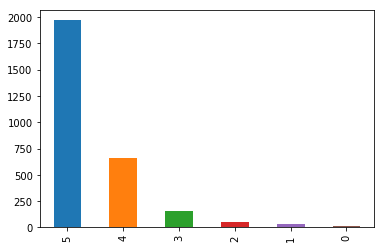

In [5]:
# Lets see the distribution of numerical ratings that were given
pd.value_counts(sample_reviews_df['rating']).plot.bar()

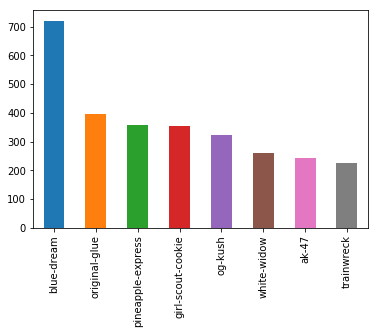

In [6]:
# Lets see the distribution of strains that were reviewed
pd.value_counts(sample_reviews_df['strain_id']).plot.bar()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0,0,'blue-dream'),
 Text(0,0,'girl-scout-cookie'),
 Text(0,0,'og-kush'),
 Text(0,0,'original-glue'),
 Text(0,0,'white-widow'),
 Text(0,0,'pineapple-express'),
 Text(0,0,'trainwreck'),
 Text(0,0,'ak-47')]

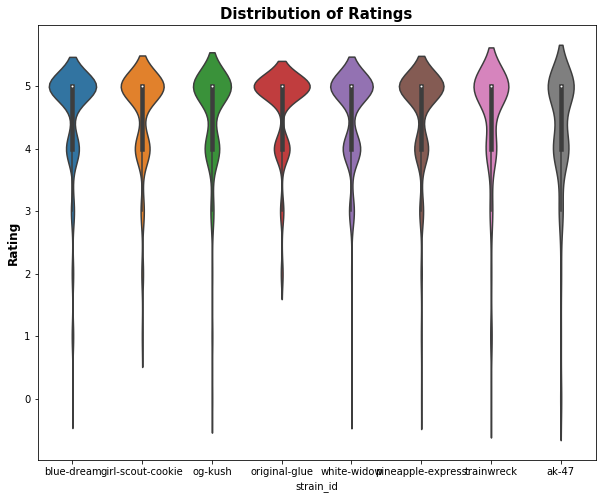

In [7]:
# Lets now look at distribution of ratings over each strain with violin plot
plt.figure(figsize=(10,8))
ax = sns.violinplot(x="strain_id", y="rating", data=sample_reviews_df)
ax.set_title("Distribution of Ratings",fontsize= 15, fontweight='bold')
ax.set_ylabel("Rating", fontsize= 12, fontweight='bold')
ax.set_xticklabels(labels =['blue-dream','girl-scout-cookie', 'og-kush', 'original-glue', 'white-widow', 'pineapple-express', 'trainwreck', 'ak-47'])

### Lets now begin with some text analysis

#### Lets get our first reading from a simple lexicon based approach with no pre processing

In [8]:
# Here we define a function that can get lexicon based sentiment
def calculate_text_polarity(x):
    return TextBlob(x).sentiment.polarity

In [9]:
sample_reviews_df["raw_text_lexicon_polarity"]= sample_reviews_df['comment'].apply(calculate_text_polarity)

In [10]:
# From this new data lets look at how it comares to the given rating
sample_reviews_df.loc[(-1.0 <= sample_reviews_df['raw_text_lexicon_polarity']) & (-0.4 >= sample_reviews_df['raw_text_lexicon_polarity']), 'raw_text_lexicon_rating'] = 1
sample_reviews_df.loc[(-0.4 <= sample_reviews_df['raw_text_lexicon_polarity']) & (-0.8 >= sample_reviews_df['raw_text_lexicon_polarity']), 'raw_text_lexicon_rating'] = 2
sample_reviews_df.loc[(-0.8 <= sample_reviews_df['raw_text_lexicon_polarity']) & (0.20 >= sample_reviews_df['raw_text_lexicon_polarity']), 'raw_text_lexicon_rating'] = 3
sample_reviews_df.loc[(0.20 <= sample_reviews_df['raw_text_lexicon_polarity']) & (0.60 >= sample_reviews_df['raw_text_lexicon_polarity']), 'raw_text_lexicon_rating'] = 4
sample_reviews_df.loc[(0.60 <= sample_reviews_df['raw_text_lexicon_polarity']) & (1.0 >= sample_reviews_df['raw_text_lexicon_polarity']), 'raw_text_lexicon_rating'] = 5

In [11]:
# Lets now check howm it performed
print(sample_reviews_df[(sample_reviews_df['rating'] == sample_reviews_df['raw_text_lexicon_rating'])].count())
print(sample_reviews_df.shape)

username                     675
comment                      675
rating                       675
strain_id                    675
raw_text_lexicon_polarity    675
raw_text_lexicon_rating      675
dtype: int64
(2882, 6)


###### So Here we can see that with this method we have an invered rating accuracy of 23% (675/2882 )

#### Now lets process the text and try to get a better result, still using lexicon method

In [12]:
def remove_html_tags(sentence):
    return re.sub(re.compile('<.*?>'), '', str(sentence))

def remove_URLS(sentence):
    return re.sub(re.compile('http\S+|www\.\S+'), '', str(sentence))

def remove_breaks(sentence):
    return re.sub(re.compile('\n|\r|\t'), '', str(sentence))

def remove_unicode(sentence):
    return unidecode.unidecode(str(sentence))

# Put it all together (Order is important)
def apply_basic_cleaning(sentence):
    iteration_one = remove_html_tags(sentence)
    iteration_two = remove_URLS(iteration_one)
    iteration_three = remove_breaks(iteration_two)
    return remove_unicode(iteration_three)

#### Here we can npw apply the preliminary cleaning 

In [15]:
sample_reviews_df['cleaned_comments'] = sample_reviews_df['comment'].apply(apply_basic_cleaning)

#### Now Add some addition Proccessing 

In [19]:
available_stop_words = corpus.stopwords.words()

def check_spelling(sentence):
    
    correct_spelling = ""
    
    for word, tag in pos_tag(wordpunct_tokenize(str(sentence))):
        correct_spelling += " "
        # here we want to keep the nouns with their original spelling 
        if tag.startswith("NNP"):
            correct_spelling += word
        else:
            correct_spelling += str(TextBlob(word).correct())
    return correct_spelling

def remove_stop_words_and_lemmatize(sentence):
    
    word_net_lemmatizer = WordNetLemmatizer()
    new_text = ""
    for word, tag in pos_tag(wordpunct_tokenize(str(sentence))):
        if word.lower() not in available_stop_words:
            new_text += " "
            if tag.startswith("NN"): #Noun
                new_text += word_net_lemmatizer.lemmatize(word, pos='n')
            elif tag.startswith('VB'): #Verb
                new_text += word_net_lemmatizer.lemmatize(word, pos='v')
            elif tag.startswith('RB'): #Adverb
                new_text += word_net_lemmatizer.lemmatize(word, pos='r')
            elif tag.startswith('JJ'): #Adjective
                new_text += word_net_lemmatizer.lemmatize(word, pos='a')
            else:
                new_text += word
    return new_text

def remove_numbers(sentence):
    return re.sub(re.compile('\d+'), '', str(sentence))

def lower_case(sentence):
    return str(sentence).lower()

def remove_punctuation(sentence):
    return re.sub(re.compile('[^\w\s]'), '', str(sentence))

def apply_advanced_cleaning(sentence):
    #iteration_one = check_spelling(sentence)
    iteration_two = remove_stop_words_and_lemmatize(sentence)
    iteration_three = remove_numbers(iteration_two)
    iteration_four = remove_punctuation(iteration_three)
    return lower_case(iteration_four)

#### Here we can npw apply the advanced cleaning 

In [20]:
sample_reviews_df['advanced_cleaned_comments'] = sample_reviews_df['cleaned_comments'].apply(apply_advanced_cleaning)

In [21]:
sample_reviews_df["advanced_cleaned_lexicon_polarity"]= sample_reviews_df['advanced_cleaned_comments'].apply(calculate_text_polarity)

In [22]:
# From this new data lets look at how it comares to the given rating
sample_reviews_df.loc[(-1.0 <= sample_reviews_df['advanced_cleaned_lexicon_polarity']) & (-0.4 >= sample_reviews_df['advanced_cleaned_lexicon_polarity']), 'advanced_cleaned_lexicon_rating'] = 1
sample_reviews_df.loc[(-0.4 <= sample_reviews_df['advanced_cleaned_lexicon_polarity']) & (-0.8 >= sample_reviews_df['advanced_cleaned_lexicon_polarity']), 'advanced_cleaned_lexicon_rating'] = 2
sample_reviews_df.loc[(-0.8 <= sample_reviews_df['advanced_cleaned_lexicon_polarity']) & (0.20 >= sample_reviews_df['advanced_cleaned_lexicon_polarity']), 'advanced_cleaned_lexicon_rating'] = 3
sample_reviews_df.loc[(0.20 <= sample_reviews_df['advanced_cleaned_lexicon_polarity']) & (0.60 >= sample_reviews_df['advanced_cleaned_lexicon_polarity']), 'advanced_cleaned_lexicon_rating'] = 4
sample_reviews_df.loc[(0.60 <= sample_reviews_df['advanced_cleaned_lexicon_polarity']) & (1.0 >= sample_reviews_df['advanced_cleaned_lexicon_polarity']), 'advanced_cleaned_lexicon_rating'] = 5

In [26]:
# Lets now check how it performed

print(sample_reviews_df[(sample_reviews_df['rating'] == sample_reviews_df['advanced_cleaned_lexicon_rating'])].count())
print(sample_reviews_df.shape)

username                             648
comment                              648
rating                               648
strain_id                            648
raw_text_lexicon_polarity            648
raw_text_lexicon_rating              648
cleaned_comments                     648
advanced_cleaned_comments            648
advanced_cleaned_lexicon_polarity    648
advanced_cleaned_lexicon_rating      648
dtype: int64
(2882, 10)


###### So Here we can see that with this method we have an invered rating accuracy of 22.4% (648/2882 )

In [29]:
# Lets now compare it to the other computed rating 

print(sample_reviews_df[(sample_reviews_df['raw_text_lexicon_rating'] == sample_reviews_df['advanced_cleaned_lexicon_rating'])].count())
print(sample_reviews_df.shape)

username                             2535
comment                              2535
rating                               2535
strain_id                            2535
raw_text_lexicon_polarity            2535
raw_text_lexicon_rating              2535
cleaned_comments                     2535
advanced_cleaned_comments            2535
advanced_cleaned_lexicon_polarity    2535
advanced_cleaned_lexicon_rating      2535
dtype: int64
(2882, 10)


######  This is quite interesting as we can see that the advanced cleaned data actually performed slightly worse than the raw text. We can also see that the raw text NLP rating and Cleaned NLP rating were the same 88% of the time.

##### No lets try It with the data that only went through partial cleaning...

In [30]:
sample_reviews_df["partial_cleaned_lexicon_polarity"]= sample_reviews_df['cleaned_comments'].apply(calculate_text_polarity)

In [31]:
# From this new data lets look at how it comares to the given rating
sample_reviews_df.loc[(-1.0 <= sample_reviews_df['partial_cleaned_lexicon_polarity']) & (-0.4 >= sample_reviews_df['partial_cleaned_lexicon_polarity']), 'partial_cleaned_lexicon_rating'] = 1
sample_reviews_df.loc[(-0.4 <= sample_reviews_df['partial_cleaned_lexicon_polarity']) & (-0.8 >= sample_reviews_df['partial_cleaned_lexicon_polarity']), 'partial_cleaned_lexicon_rating'] = 2
sample_reviews_df.loc[(-0.8 <= sample_reviews_df['partial_cleaned_lexicon_polarity']) & (0.20 >= sample_reviews_df['partial_cleaned_lexicon_polarity']), 'partial_cleaned_lexicon_rating'] = 3
sample_reviews_df.loc[(0.20 <= sample_reviews_df['partial_cleaned_lexicon_polarity']) & (0.60 >= sample_reviews_df['partial_cleaned_lexicon_polarity']), 'partial_cleaned_lexicon_rating'] = 4
sample_reviews_df.loc[(0.60 <= sample_reviews_df['partial_cleaned_lexicon_polarity']) & (1.0 >= sample_reviews_df['partial_cleaned_lexicon_polarity']), 'partial_cleaned_lexicon_rating'] = 5

In [32]:
# Lets now check how it performed

print(sample_reviews_df[(sample_reviews_df['rating'] == sample_reviews_df['partial_cleaned_lexicon_rating'])].count())
print(sample_reviews_df.shape)

username                             675
comment                              675
rating                               675
strain_id                            675
raw_text_lexicon_polarity            675
raw_text_lexicon_rating              675
cleaned_comments                     675
advanced_cleaned_comments            675
advanced_cleaned_lexicon_polarity    675
advanced_cleaned_lexicon_rating      675
partial_cleaned_lexicon_polarity     675
partial_cleaned_lexicon_rating       675
dtype: int64
(2882, 12)


###### So Here we can see that with this method we have an invered rating accuracy of 23.4% (675/2882)

######  We can now see that with this data set, applying spellcheck, lematization, removal of punctuiation actuallly resulted in a worse performance

##### Now lets look at the distrivution of our best case created reviews

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0,0,'blue-dream'),
 Text(0,0,'girl-scout-cookie'),
 Text(0,0,'og-kush'),
 Text(0,0,'original-glue'),
 Text(0,0,'white-widow'),
 Text(0,0,'pineapple-express'),
 Text(0,0,'trainwreck'),
 Text(0,0,'ak-47')]

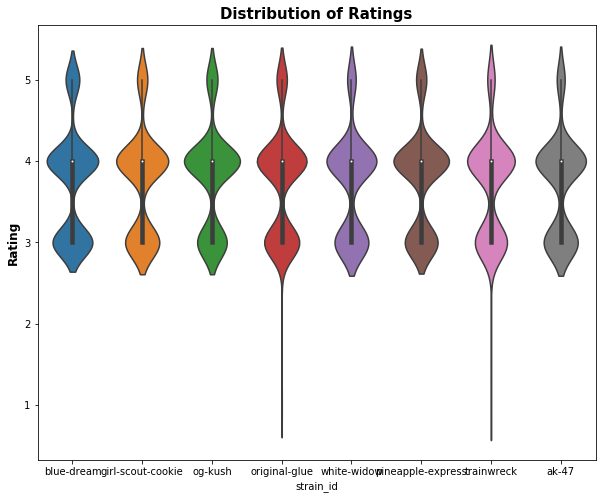

In [33]:
# Lets now look at distribution of ratings over each strain with violin plot
plt.figure(figsize=(10,8))
ax = sns.violinplot(x="strain_id", y="partial_cleaned_lexicon_rating", data=sample_reviews_df)
ax.set_title("Distribution of Ratings",fontsize= 15, fontweight='bold')
ax.set_ylabel("Rating", fontsize= 12, fontweight='bold')
ax.set_xticklabels(labels =['blue-dream','girl-scout-cookie', 'og-kush', 'original-glue', 'white-widow', 'pineapple-express', 'trainwreck', 'ak-47'])

######  We can see now that the data is much more spread out that the original ratings but still keeping a high percentage in the "high review" range. We can also see that it did NOT perform well with negative reviews as a lot of the tails have been clipped off

######  Taking away from this the productized version in the API will, when a new review comes in, pass the comment through the partial cleaning, get the polarity and subjectivity and add it to the review object in the Database. An Daily occuring cronjob will then, foir each strain, calculate the average polarity and sentiment across all reviews to then be factored into the prediction algorithM